nodes.shape=(3, 10, 10, 2)


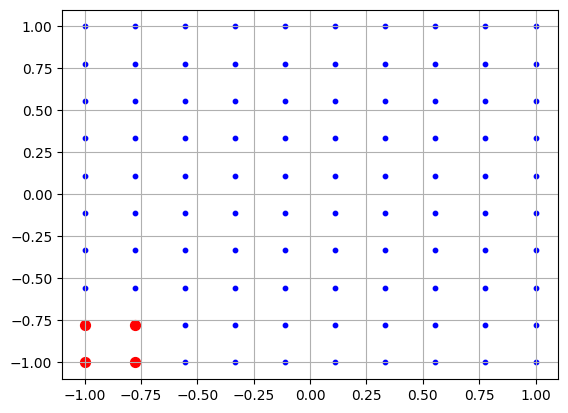

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = 3
# Choose starting positions of robots
B_k = np.array([[2,3],[4,4],[9,9]])

# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 10
#fuel capacity for a robot, represented as the length in nodes: for the 1 depot case, has to be AT LEAST 2*(2*(n-1)) to fit the constraint of the problem "It is assumed that 
#for each target point, there is a depot that is reachable by expending at most L/2 of the fuel."
fuel_capacity = 2*(2*(n-1))
max_fuel_expenditure = 2*(n-1)
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
nodes = nodes.reshape((1,) + nodes.shape)
nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
depots_i = np.array([[0, 0],[0,1],[1,1],[1,0]])
## Four depot nodes (one in each corner)
# depots_i = np.array([[0, 0], [0, n-1], [n-1, 0], [n-1,n-1]])

# Graphical sanity check
plt.figure()
plt.scatter(nodes[0,:,:,0], nodes[0,:,:,1], c='blue', s=10)
plt.scatter(nodes[0,depots_i[:,0],depots_i[:,1],0], nodes[0,depots_i[:,0],depots_i[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = (1. + q_k) * np.sqrt((nodes[0,i1,j1,0]-nodes[0,i2,j2,0]) ** 2 + (nodes[0,i1,j1,1]-nodes[0,i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
cost = cost.reshape((1,) + cost.shape)
cost = np.concatenate([cost for _ in range(k)], axis=0)
print(f"{cost.shape=}")


cost.shape=(3, 10, 10, 10, 10)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# Set the OBJECTIVE FUNCTION
# ((1+q_k) * c_{ij}) * x^{k}_{ij}
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=int(n*n-len(depots_i)), obj=cost)
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    is_depot_involved = False
    for depots_ii in depots_i:
        if (depots_ii[0] == i1 and depots_ii[1] == j1) or (depots_ii[0] == i2 and depots_ii[1] == j2):
            is_depot_involved = True
            continue
    if is_depot_involved:
        continue
    _ = m.addConstr(x[:,i1,j1,i2,j2] <= 1)
# Above code handles A. Integer Constraints (4) and (5)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2421626
Academic license - for non-commercial use only - registered to cecummings@wpi.edu


In [4]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target
for ki, i1, j1 in itertools.product(range(k), range(n), range(n)):
    for d in depots_i:
        if not ((i1 == B_k[ki][0] and j1 == B_k[ki][1]) or (i1 == d[0] and j1 == d[1])): 
            _ = m.addConstr(x[:,i1,j1,:,:].sum() == 1)
            _ = m.addConstr(x[:,:,:,i1,j1].sum() == 1)
    
# (8) and (9) Begin and end at same position B_k
_ = m.addConstrs(x[ki,B_k[ki][0],B_k[ki][1],:,:].sum() <= 1 for ki in range(k))
_ = m.addConstrs(x[ki,:,:,B_k[ki][0],B_k[ki][1]].sum() <= 1 for ki in range(k))
# (10) Every robot that visits a target leaves the target
_ = m.addConstrs(x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:] == 0 for ki in range(k) for i1 in range(n) for j1 in range(n))

# Additional constraints: no loopholes!
#_ = m.addConstrs(x[ki, i, j, i, j] == 0 for ki in range(k) for i in range(n) for j in range(n))
# Additional Constraints: symmetry!
#_ = m.addConstrs(x[ki, i1, j1, i2, j2] == x[ki, i2, j2, i1, j1] for ki in range(k) for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))

In [ ]:
# C. Degree Constraints (11), (12), (13), (14)
# This may be a lazy constraint because it is about sub tour elimination.
p = m.addMVar((n,n,n,n), name='p', vtype=GRB.INTEGER)
for ki in range(k):
    for d in depots_i: #(i1, j1) N\Bk, (i2, j2) T\Bk
        #(13)
        _ = m.addConstr((p[:, :, d[0], d[1]] - p[d[0], d[1], :, :]).sum() == 0)
        for i1, j1, i2, j2, i3, j3 in itertools.product(range(n), range(n), range(n), range(n), range(n), range(n)):
            if not ((i1 == B_k[ki][0] and j1 == B_k[ki][1]) or (i2 == B_k[ki][0] and j2 == B_k[ki][1]) or (i2 == d[0] and j2 == d[1])):
                #(11)
                _ = m.addConstr((p[B_k[0], B_k[1], i1, j1] - p[i1, j1, B_k[0], B_k[1]]).sum() == x[ki,i2,j2,:,:].sum()) 
                #(12)
                _ = m.addConstr((p[i2, j2, :, :] - p[:, :, i2, j2]).sum() == x[ki,i2,j2,:,:].sum())

#(14)
_ = m.addConstrs(p[i1,j1,:,:] >= 0 for ki in range(k) for i1 in range(n) for j1 in range(n))
_ = m.addConstrs(p[i1,j1,:,:] <= fuel_capacity*x[ki,i1,j1,:,:] for ki in range(k) for i1 in range(n) for j1 in range(n))

In [ ]:
# Fuel Constraints (15), (16), (17), (18), (19), (20)
# This includes adding another decision variable

from queue import PriorityQueue
import math
import itertools
#https://www.redblobgames.com/pathfinding/a-star/implementation.html#python-astar
def neighbors(curr):
    ns = [(curr[0]+1, curr[1]), (curr[0]-1, curr[1]), (curr[0], curr[1]+1), (curr[0], curr[1]-1), (curr[0]+1, curr[1]+1), (curr[0]-1, curr[1]-1), (curr[0]+1, curr[1]-1), (curr[0]-1, curr[1]+1)]
    neighbors = []
    for n in ns:
        if n[0] <= 9 and n[0] >= 0 and n[1] <= 9 and n[1] >= 0:    
            neighbors.append(n)
    return neighbors

#there are absolutely better ways to do this, this is just the one that took me 10 minutes to do.
def a_star_search(i1, j1, i2, j2):
    frontier = PriorityQueue()
    frontier.put((i1,j1), 0)
    came_from = dict()
    cost_so_far = dict()
    came_from[(i1,j1)] = None
    cost_so_far[(i1,j1)] = 0
    
    
    while not frontier.empty():
        current = frontier.get()
        if current == (i2, j2):
            break

        for next in neighbors(current):
            new_cost = cost_so_far[current] + math.dist(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost #+ math.dist(next, (i2,j2))
                frontier.put(next, priority)
                came_from[next] = current
                
    curr_val = (i2, j2)
    final_path = []
    while curr_val != (i1, j1):
        final_path.append(curr_val)
        curr_val = came_from[curr_val]
            
    final_path.append((i1, j1))
    final_path.reverse()
    
    return final_path
# Fuel Constraints (15), (16), (17), (18), (19), (20)
# This includes adding another decision variable
ri = model.addVar(1, name='ri', vtype=GRB.INTEGER)
rj = model.addVar(1, name='rj', vtype=GRB.INTEGER)

for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    fij = len(a_star_search(i1,j1,i2,j2))
    _ = model.addConstr(rj-ri+fij <= (fuel_capacity+max_fuel_expenditure)*(1-x[:,i1,j1,:,:])) #(15)
    _ = model.addConstr(rj-ri+fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[:,i1,j1,:,:])) #(16)

    #(20)
    _ = model.addConstr(0<=ri)
    _ = model.addConstr(ri<=fuel_capacity)
    for depot in depots_i:
        if i1 == depot[0] and j1 == depot[1]:
            _ = model.addConstr(rj-fuel_capacity+fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[:,i1,j1,depot[0],depot[1]])) #(17)
            _ = model.addConstr(rj-fuel_capacity+fij <= (fuel_capacity+max_fuel_expenditure)*(1-x[:,i1,j1,depot[0],depot[1]])) #(18)
        if i2 == depot[0] and j2 == depot[1]:
            _ = model.addConstr(ri-fij >= -(fuel_capacity+max_fuel_expenditure)*(1-x[:,depot[0],depot[1],i2,j2])) #(19)

In [ ]:
m._vars = x
#m.Params.lazyConstraints = 1
m.optimize()
#m.optimize()
#for ki, i1, j1, i2, j2 in itertools.product(range(k), range(n), range(n), range(n), range(n)):
#    if m._vars.x[ki][i1][j1][6][6] > 0 or m._vars.x[ki][6][6][i2][j2] > 0:
#        print(i1,j1)

#print(x_values)
robot_paths = [[] for _ in range(k)]
for ki in range(k):
    print("Robot #:", k)
    for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
        #tour = subtour(np.transpose(np.where(m._vars.x[ki] > 0.5)))
        if m._vars.x[ki][i1][j1][i2][j2] > 0.5:
            print(i1,j1,i2,j2)
            robot_paths[ki].append([i1,j1,i2,j2]) 

print(robot_paths)

In [ ]:
shortest_tours = []
selected = m._vars.x
for ki in range(k):
    shortest_tour, all_tours = subtour(np.transpose(np.where(m._vars.x[ki] > 0.5)))
    print(shortest_tour)
    #shortest_tour.append(shortest_tour[0])
    #shortest_tours.append(shortest_tour)
    #print(f"robot #{ki}")
    #print(f"Shortest Tour: {shortest_tour}")
    # for i, t in enumerate(all_tours):
    #     print(f"Tour #{i}: {all_tours}")
    #print("-" * 50)


In [ ]:
# Graphical sanity check for the tour
for ki, tour in enumerate(shortest_tours):
    fig = plt.figure()
    fig.suptitle(f"Path for robot #{ki}")
    plt.scatter(nodes[0, :, :, 0], nodes[0, :, :, 1], c='blue', s=10)
    plt.scatter(nodes[0, depots_i[:, 0], depots_i[:, 1], 0], nodes[0, depots_i[:, 0], depots_i[:, 1], 1], c='red', s=50)
    tour_np = np.array([]).reshape(0, 2)
    for i, j in tour:
        plt.scatter(nodes[0, i, j, 0], nodes[0, i, j, 1], c="green", s=8)
        tour_np = np.concatenate((tour_np, nodes[0, i, j].reshape(1, 2)))
    plt.plot(tour_np[:, 0], tour_np[:, 1], color="green", linewidth=1)
    plt.grid()
    plt.show()
